<a href="https://colab.research.google.com/github/imZiho/Deep-Learning_Seminar/blob/main/cha09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 9장 CNN을 활용한 이미지 인식

In [28]:
!sudo apt-get install -y fonts-nanum* | tail -n 1
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib

0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 39 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped directory detected
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache direc

In [ ]:
# 필요 라이브러리 설치

!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

In [ ]:
# 라이브러리 임포트

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# 폰트 관련 용도
import matplotlib.font_manager as fm

# 나눔 고딕 폰트의 경로 명시
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()

In [ ]:
# 파이토치 관련 라이브러리

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [ ]:
# warning 표시 끄기
import warnings
warnings.simplefilter('ignore')

# 기본 폰트 설정
plt.rcParams['font.family'] = font_name

# 기본 폰트 사이즈 변경
plt.rcParams['font.size'] = 14

# 기본 그래프 사이즈 변경
plt.rcParams['figure.figsize'] = (6,6)

# 기본 그리드 표시
# 필요에 따라 설정할 때는, plt.grid()
plt.rcParams['axes.grid'] = True

# 마이너스 기호 정상 출력
plt.rcParams['axes.unicode_minus'] = False

# 넘파이 부동소수점 자릿수 표시
np.set_printoptions(suppress=True, precision=4)

CNN을 특징짓는 것은 합성곱의 처리와 풀링처리이다.

합성곱의 처리는 CNN의 핵심 구성 요소 중 하나로, 이 층은 입력 이미지에 대한 작은 필터(커널)를 슬라이딩하면서 이미지의 특징을 감지한다.

각 필터는 입력 이미지와 내적 연산을 수행하여 특정 패턴이나 특징을 찾아낸다


여러 개의 필터가 사용되며, 각각은 서로 다른 특징을 검출하도록 학습된다.

풀링 층 (Pooling Layer):

풀링 층은 공간 차원(너비와 높이)을 줄이는 역할을 한다.

주로 최대 풀링(Max Pooling)이 사용되며, 특정 영역에서 가장 큰 값을 선택하여 정보를 압축한다.

이를 통해 계산량을 줄이고, 모델이 공간적으로 불변한 특징을 학습할 수 있도록 돕는다.

### GPU 확인하기

In [ ]:
# 디바이스 할당

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 9.3 CNN의 처리 개요

In [ ]:
data_root = './data'

# 샘플 손글씨 숫자 데이터 가져오기
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_set = datasets.MNIST(
    root = data_root,  train = True,
    download = True, transform = transform)

image, label = train_set[0]
image = image.view(1,1,28,28)

100%|██████████| 9912422/9912422 [00:00<00:00, 124748590.49it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 62184647.75it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 39790637.87it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5325839.75it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# 대각선상에만 가중치를 갖는 특수한 합성곱 함수를 만듦
conv1 = nn.Conv2d(1, 1, 3)      #  이 부분은 PyTorch의 nn.Conv2d 모듈을 사용하여 첫 번째 합성곱 층을 정의한다(입력채널,출력채널,필터의 크키)

# bias를 0으로
nn.init.constant_(conv1.bias, 0.0)

# weight를 특수한 값으로
w1_np = np.array([[0,0,1],[0,1,0],[1,0,0]])
w1 = torch.tensor(w1_np).float()
w1 = w1.view(1,1,3,3)   #합성곱 층에서 가중치 텐서의 형태는 (출력 채널 수, 입력 채널 수, 커널 높이, 커널 너비)여야 함. 여기에서는 출력 채널 및 입력 채널이 각각 1이므로 (1, 1, 3, 3) 형태로 변경
conv1.weight.data = w1

 PyTorch를 사용하여 합성곱 신경망(Convolutional Neural Network, CNN)의 첫 번째 합성곱 층을 정의하고 가중치(weight) 및 편향(bias)을 초기화하는 과정을 수행한다.

##이 코드의 목적은 합성곱 층의 가중치와 편향을 특정 값으로 초기화하는 것.

이렇게 초기화된 합성곱 층은 특정한 패턴을 감지하기 위해 사용될 것이며, 이 패턴은 가중치 w1에 정의된 대로 중앙에 1이 있는 패턴임.

In [ ]:
# 손글씨 숫자에 3번 합성곱 처리를 함
image, label = train_set[0]
image = image.view(1,1,28,28)
w1 = conv1(image)
w2 = conv1(w1)
w3 = conv1(w2)
images = [image, w1, w2, w3]

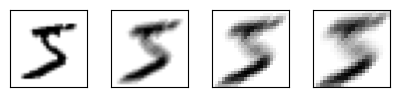

In [ ]:
# 결과 화면 출력

plt.figure(figsize=(5, 1))
for i in range(4):
    size = 28 - i*2
    ax = plt.subplot(1, 4, i+1)
    img = images[i].data.numpy()
    plt.imshow(img.reshape(size, size),cmap='gray_r')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 9.4 파이토치에서 CNN을 구현하는 방법(여기서부터 책)

### nn.Conv2d 와 nn.MaxPool2d

nn.Conv2d는 PyTorch에서 제공하는 합성곱 연산(Convolutional Operation)을 수행하는 모듈이다.

nn.MaxPool2d는 PyTorch에서 제공하는 최대 풀링(Max Pooling) 연산을 수행하는 모듈이다

In [ ]:
# CNN 모델 전반 부분, 레이어 함수 정의

conv1 = nn.Conv2d(3, 32, 3)     # 첫 번째 합성곱 층을 정의. nn.Conv2d 모듈의 사용법으로,(in_channels, out_channels, kernel_size) 여기서는 컬러이미지를 다루기에 3
relu = nn.ReLU(inplace=True)    # inplace=True를 설정하면 활성화 함수가 입력 데이터를 직접 수정하고 추가 메모리를 사용하지 않도록 설정하는 것
conv2 = nn.Conv2d(32, 32, 3)    # 두 번째 합성곱 층을 정의한다
maxpool = nn.MaxPool2d((2,2))   # 최대 풀링(Max Pooling) 층을 정의한다(풀링 함수는 nn.Maxpool2d라는 레이어함수를 사용)

이 코드 조각은 일반적으로 CNN 모델의 초기 부분을 정의하며, 입력 이미지에서 특징을 추출하는 역할을 합니다.

이후에는 이러한 레이어를 순서대로 쌓아 전체 CNN 아키텍처를 완성하게 됩니다.

In [ ]:
# conv1 확인
print(conv1)

# conv1 내부 변수의 shape 확인
print(conv1.weight.shape)
print(conv1.bias.shape)

# conv2 내부 변수의 shape 확인
print(conv2.weight.shape)
print(conv2.bias.shape)

Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])


conv1.weight.shape을 사용하여 가중치 텐서의 shape를 확인할 수 있습니다.

이 텐서의 shape는 (출력 채널 수, 입력 채널 수, 커널 높이, 커널 너비)입니다.


conv1.bias.shape를 사용하여 편향 텐서의 shape를 확인할 수 있습니다. 편향 텐서의 shape는 (출력 채널 수,)입니다.

In [ ]:
# conv1의 weight[0]는 0번째 출력 채널의 가중치
w = conv1.weight[0]   # conv1 레이어의 첫 번째 출력 채널에 해당하는 가중치 텐서를 가져와 w 변수에 할당한 후

# weight[0]의 shape과 값 확인
print(w.shape)    # w의 shape(크기)를 출력
print(w.data.numpy())   #  w의 값을 NumPy 배열로 변환하여 출력

torch.Size([3, 3, 3])
[[[-0.0233  0.071   0.1894]
  [ 0.0207 -0.1162  0.0113]
  [-0.086  -0.1803 -0.1441]]

 [[ 0.1008  0.1156 -0.1013]
  [-0.1597  0.0107 -0.1266]
  [ 0.1264  0.1458  0.1656]]

 [[-0.0129  0.1528 -0.0333]
  [-0.0648 -0.0062 -0.1073]
  [-0.0462 -0.0676 -0.0764]]]


In [ ]:
# 더미로 입력과 같은 사이즈를 갖는 텐서를 생성
inputs = torch.randn(100, 3, 32, 32)
print(inputs.shape)

torch.Size([100, 3, 32, 32])


In [ ]:
# CNN 전반부 처리 시뮬레이션

x1 = conv1(inputs)  # x1 = conv1(inputs): inputs를 첫 번째 합성곱 레이어 conv1에 전달하여 특징 맵 x1을 생성
x2 = relu(x1)       # ReLU(Rectified Linear Unit) 활성화 함수를 적용하여 활성화된 특징 맵 x2를 생성
x3 = conv2(x2)      # x2를 두 번째 합성곱 레이어 conv2에 전달하여 또 다른 특징 맵 x3을 생성
x4 = relu(x3)       # x3에 다시 ReLU 활성화 함수를 적용하여 활성화된 특징 맵 x4을 생성
x5 = maxpool(x4)    # x4에 최대 풀링(Max Pooling) 연산을 적용하여 최종 특징 맵 x5를 생성

In [ ]:
# 각 변수의 shape 확인

print(inputs.shape)
print(x1.shape)
print(x2.shape)
print(x3.shape)
print(x4.shape)
print(x5.shape)

torch.Size([100, 3, 32, 32])
torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 14, 14])


### nn.Sequential

In [ ]:
# 함수 정의
features = nn.Sequential(
    conv1,
    relu,
    conv2,
    relu,
    maxpool
)

In [ ]:
# 동작 테스트
outputs = features(inputs)

# 결과 확인
print(outputs.shape)

torch.Size([100, 32, 14, 14])


### nn.Flatten

In [ ]:
# 함수 정의
flatten = nn.Flatten()

# 동작 테스트
outputs2 = flatten(outputs)

# 결과 확인
print(outputs.shape)
print(outputs2.shape)

torch.Size([100, 32, 14, 14])
torch.Size([100, 6272])


## 9.5 공통 함수 사용하기

### eval_loss(손실 계산)

In [ ]:
# 손실 계산용
def eval_loss(loader, device, net, criterion):

    # 데이터로더에서 처음 한 개 세트를 가져옴
    for images, labels in loader:
        break

    # 디바이스 할당
    inputs = images.to(device)
    labels = labels.to(device)

    # 예측 계산
    outputs = net(inputs)

    # 손실 계산
    loss = criterion(outputs, labels)

    return loss

### fit(학습)

In [ ]:
# 학습용 함수
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    # tqdm 라이브러리 임포트
    from tqdm.notebook import tqdm

    base_epochs = len(history)

    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        # 훈련 페이즈
        net.train()
        count = 0

        for inputs, labels in tqdm(train_loader):
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 경사 초기화
            optimizer.zero_grad()

            # 예측 계산
            outputs = net(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # 경사 계산
            loss.backward()

            # 파라미터 수정
            optimizer.step()

            # 예측 라벨 산출
            predicted = torch.max(outputs, 1)[1]

            # 정답 건수 산출
            train_acc += (predicted == labels).sum().item()

            # 손실과 정확도 계산
            avg_train_loss = train_loss / count
            avg_train_acc = train_acc / count

        # 예측 페이즈
        net.eval()
        count = 0

        for inputs, labels in test_loader:
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 예측 계산
            outputs = net(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # 예측 라벨 산출
            predicted = torch.max(outputs, 1)[1]

            # 정답 건수 산출
            val_acc += (predicted == labels).sum().item()

            # 손실과 정확도 계산
            avg_val_loss = val_loss / count
            avg_val_acc = val_acc / count

        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history

### eval_history(학습 로그)

In [ ]:
# 학습 로그 해석

def evaluate_history(history):
    # 손실과 정확도 확인
    print(f'초기상태 : 손실 : {history[0,3]:.5f}  정확도 : {history[0,4]:.5f}')
    print(f'최종상태 : 손실 : {history[-1,3]:.5f}  정확도 : {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    # 학습 곡선 출력(손실)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='훈련')
    plt.plot(history[:,0], history[:,3], 'k', label='검증')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('반복 횟수')
    plt.ylabel('손실')
    plt.title('학습 곡선(손실)')
    plt.legend()
    plt.show()

    # 학습 곡선 출력(정확도)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='훈련')
    plt.plot(history[:,0], history[:,4], 'k', label='검증')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('반복 횟수')
    plt.ylabel('정확도')
    plt.title('학습 곡선(정확도)')
    plt.legend()
    plt.show()

### show_images_labels(예측 결과 표시)

In [ ]:
# 이미지와 라벨 표시
def show_images_labels(loader, classes, net, device):

    # 데이터로더에서 처음 1세트를 가져오기
    for images, labels in loader:
        break
    # 표시 수는 50개
    n_size = min(len(images), 50)

    if net is not None:
      # 디바이스 할당
      inputs = images.to(device)
      labels = labels.to(device)

      # 예측 계산
      outputs = net(inputs)
      predicted = torch.max(outputs,1)[1]
      #images = images.to('cpu')

    # 처음 n_size개 표시
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        # net이 None이 아닌 경우는 예측 결과도 타이틀에 표시함
        if net is not None:
          predicted_name = classes[predicted[i]]
          # 정답인지 아닌지 색으로 구분함
          if label_name == predicted_name:
            c = 'k'
          else:
            c = 'b'
          ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        # net이 None인 경우는 정답 라벨만 표시
        else:
          ax.set_title(label_name, fontsize=20)
        # 텐서를 넘파이로 변환
        image_np = images[i].numpy().copy()
        # 축의 순서 변경 (channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        # 값의 범위를[-1, 1] -> [0, 1]로 되돌림
        img = (img + 1)/2
        # 결과 표시
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()


### torch_seed(난수 초기화)

In [27]:
# 파이토치 난수 고정

def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True